In [1]:
# Temporary import. It will be removed in the final vserion
import os
import sys

import os
os.chdir('/Users/zhanwenxin/Documents/GitHub/cuTAGI-LSTM')

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm

import pytagi.metric as metric
from pytagi import Normalizer as normalizer
from pytagi import exponential_scheduler
from pytagi.nn import LSTM, Linear, Sequential
from pytagi.LSTM_KF_RL_Env import LSTM_KF_Env

from examples.data_loader import TimeSeriesDataloader, SyntheticTimeSeriesDataloader
from pytagi.hybrid import LSTM_SSM
from pytagi.hybrid import process_input_ssm

from itertools import count

In [2]:
# Dataset
output_col = [0]
num_features = 2
input_seq_len = 26
output_seq_len = 1
seq_stride = 1

# Network
net = Sequential(
    LSTM(num_features, 30, input_seq_len),
    LSTM(30, 30, input_seq_len),
    Linear(30 * input_seq_len, 1),
)
net.set_threads(8)
net.load(filename='./saved_param/HQ_hybrid_LSTM/lstm_hq_hybrid_onlydisp11.pth')
# #net.to_device("cuda")

# # State-space models: for baseline hidden states
phi_AA = 0.999
Sigma_AR = 0.02
Sigma_AA = Sigma_AR*1e-16
LA_var_stationary = Sigma_AA /(1-phi_AA**2)
# Autoregressive acceleration + online AR
hybrid = LSTM_SSM(
    neural_network = net,           # LSTM
    baseline = 'AA + AR', # 'level', 'trend', 'acceleration', 'ETS'
    zB  = np.array([0.1, 1E-4, 0, 0.51824134, 0.02]),    # initial mu for baseline hidden states
    SzB = np.array([1E-5, 1E-8, LA_var_stationary, 1E-16, Sigma_AR]),    # var
    phi_AA = phi_AA,
    Sigma_AR = Sigma_AR,
    Sigma_AA = Sigma_AA,
)

In [3]:
ts_mean = np.array([1.0649368, 26.64127424])
ts_std = np.array([1.0880665, 14.98919694])

test_dtl = TimeSeriesDataloader(
    x_file="data/HQ/hq_ts2.csv",
    date_time_file="data/HQ/hq_ts2_datetime.csv",
# test_dtl = SyntheticTimeSeriesDataloader(
#     x_file="data/HQ/syn_dataset_hqts2_lstm_unstandardized.csv",
#     date_time_file="data/HQ/syn_dataset_hqts2_lstm_datetime.csv",
    x_mean=ts_mean,
    x_std=ts_std,
    output_col=output_col,
    input_seq_len=input_seq_len,
    output_seq_len=output_seq_len,
    num_features=num_features,
    stride=seq_stride,
    time_covariates = ['week_of_year'],  # 'hour_of_day','day_of_week', 'week_of_year', 'month_of_year','quarter_of_year'
)

train_dtl_x_mean = np.array([1.29422196])
train_dtl_x_std = np.array([1.04736457])

In [4]:
env = LSTM_KF_Env(render_mode=None, data_loader=test_dtl, train_x_mean = train_dtl_x_mean, train_x_std = train_dtl_x_std, \
                            ts_model=hybrid, step_look_back=8)
state, _ = env.reset()

# print(state)

for t in count():
    state, reward, terminated, _, info = env.step(0)

    if terminated:
        break

In [5]:
mu_hidden_states_one_episode = np.array(info['hidden_state_one_episode']['mu'])
var_hidden_states_one_episode = np.array(info['hidden_state_one_episode']['var'])
mu_prediction_one_episode = np.array(info['prediction_one_episode']['mu']).flatten()
var_prediction_one_episode = np.array(info['prediction_one_episode']['var']).flatten()
print(mu_prediction_one_episode.shape)
print(var_prediction_one_episode.shape)

(696,)
(696,)


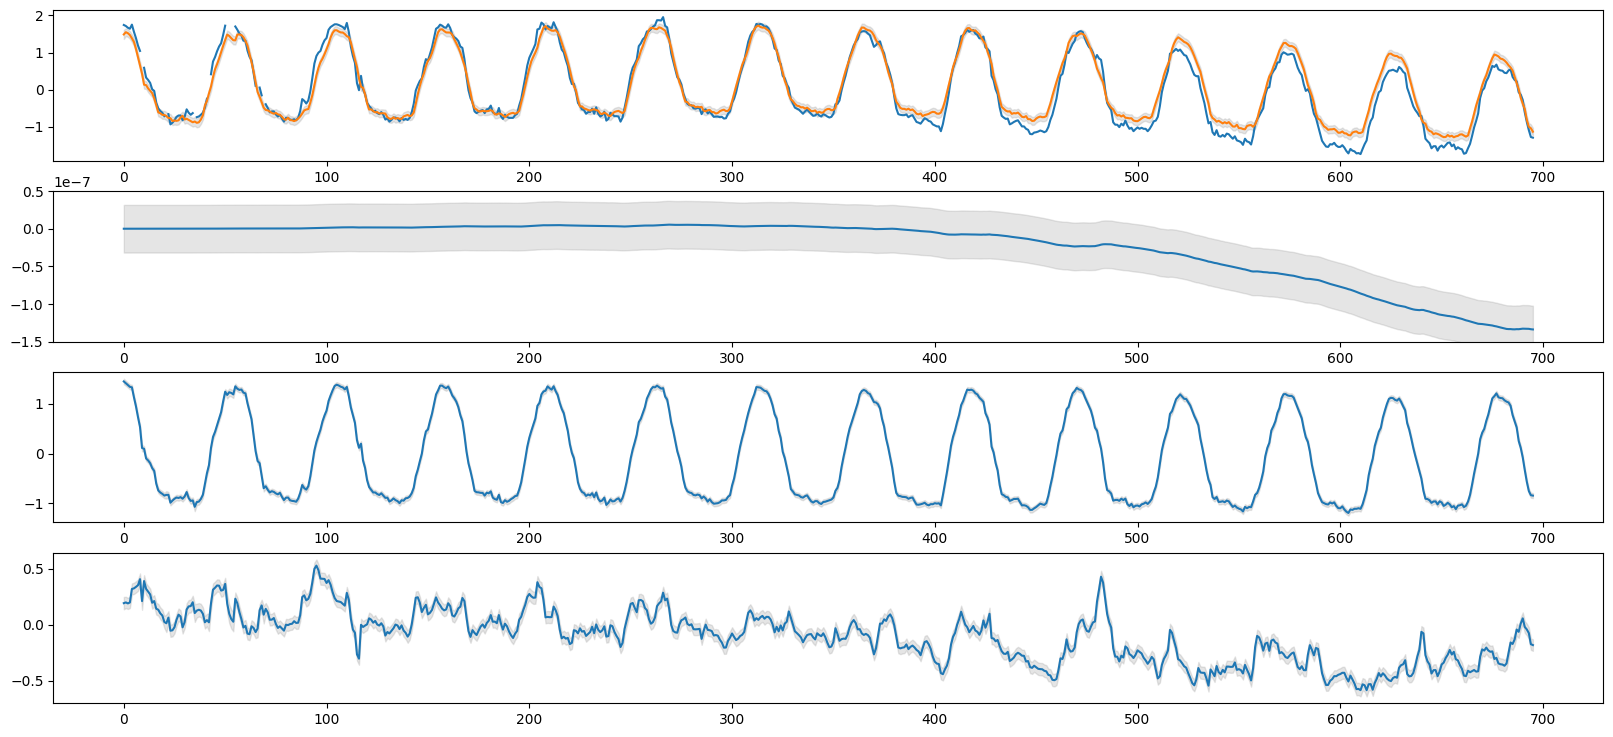

In [6]:
# Plot prediction
from matplotlib import gridspec
fig = plt.figure(figsize=(20, 9))
gs = gridspec.GridSpec(4, 1)
ax0 = plt.subplot(gs[0])
ax1 = plt.subplot(gs[1])
ax2 = plt.subplot(gs[2])
ax3 = plt.subplot(gs[3])

time_step_indices = np.arange(0, len(mu_hidden_states_one_episode[:,2]), 1)

# Plot prediction
ax0.plot(time_step_indices, info['measurement_one_episode'], label='Observation')
ax0.plot(time_step_indices, mu_prediction_one_episode, label='Prediction')
ax0.fill_between(
    time_step_indices,
    mu_prediction_one_episode - np.sqrt(var_prediction_one_episode),
    mu_prediction_one_episode + np.sqrt(var_prediction_one_episode),
    alpha=0.2,
    color='gray',
)

# Plot AA hidden states
ax1.plot(time_step_indices, mu_hidden_states_one_episode[:,2], label='AA hidden state')
ax1.fill_between(
    time_step_indices,
    mu_hidden_states_one_episode[:,2] - np.sqrt(var_hidden_states_one_episode[:,2,2]),
    mu_hidden_states_one_episode[:,2] + np.sqrt(var_hidden_states_one_episode[:,2,2]),
    alpha=0.2,
    color='gray',
)
ax1.set_ylim(-1.5e-7,0.5e-7)

# Plot LSTM hidden states
ax2.plot(time_step_indices, mu_hidden_states_one_episode[:,-1], label='LSTM hidden state')
ax2.fill_between(
    time_step_indices,
    mu_hidden_states_one_episode[:,-1] - np.sqrt(var_hidden_states_one_episode[:,-1,-1]),
    mu_hidden_states_one_episode[:,-1] + np.sqrt(var_hidden_states_one_episode[:,-1,-1]),
    alpha=0.2,
    color='gray',
)

# Plot AR hidden states
ax3.plot(time_step_indices, mu_hidden_states_one_episode[:,-2], label='AR hidden state')
ax3.fill_between(
    time_step_indices,
    mu_hidden_states_one_episode[:,-2] - np.sqrt(var_hidden_states_one_episode[:,-2,-2]),
    mu_hidden_states_one_episode[:,-2] + np.sqrt(var_hidden_states_one_episode[:,-2,-2]),
    alpha=0.2,
    color='gray',
)

plt.show()